In [ ]:
!pip install tensorflow
!pip install keras
!pip install python-opencv
!pip install tqdm

ERROR: Could not find a version that satisfies the requirement python-opencv (from versions: none)
ERROR: No matching distribution found for python-opencv


In [ ]:
cd "/content"

/content


In [ ]:
cp -r "drive/MyDrive/simpsons_images" .

In [ ]:
import matplotlib.pyplot as plt

import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:
from tensorflow.keras import regularizers

def build_encoder(img_shape):
    input_img = keras.Input(shape=img_shape +(3,))

    x = layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10), padding='same')(input_img)
    x = layers.Conv2D(256, (3, 3), kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10),padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = Dropout(0.5)(x)

    latent_dim_shape = tuple(encoded.get_shape().as_list()[1:])

    encoder = keras.Model(input_img, encoded)

    return encoder, latent_dim_shape

def build_decoder(latent_dim_shape):
    encoded = keras.Input(shape=latent_dim_shape)

    x = layers.Conv2D(256, (3, 3),kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10), padding='same')(encoded)
    x = layers.Conv2D(128, (3, 3),kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    decoded = layers.Conv2D(3, (3, 3),activation='sigmoid',kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(10e-10), padding='same')(x)

    decoder = keras.Model(encoded, decoded)
    return decoder


def build_autoencoder(encoder, decoder,initial_learning_rate):

    autoencoder = keras.Sequential()

    autoencoder.add(encoder)
    autoencoder.add(decoder)

    optimizer = keras.optimizers.Adam(lr=initial_learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])

    return autoencoder

In [ ]:
def visualize(img,encoder,decoder):
    #https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    print('encoding shape:', code.shape)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1],-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco)
    plt.show()



def show_img(img):
    plt.imshow(img)
    plt.show()

def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
assert tf.test.is_gpu_available()
assert tf.test.is_built_with_cuda()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


reloading images
dataset shape: (9000, 64, 64, 3)


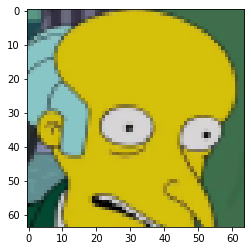

In [ ]:

dim = (64, 64)

saved_imgs = '/content/simpsons_images/images - Copy.npy'
print('reloading images')

images = np.load(saved_imgs)
print('dataset shape:', images.shape)




X = images.astype('float32') / 255.0
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

show_img(X_train[0])

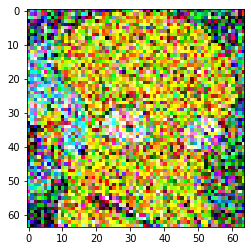

In [ ]:
noise_factor = 0.4
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

show_img(X_train_noisy[0])

training from scratch
latent dimention: (32, 32, 256)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 32, 32, 256)       299776    
_________________________________________________________________
model_1 (Functional)         (None, 64, 64, 3)         889091    
Total params: 1,188,867
Trainable params: 1,188,099
Non-trainable params: 768
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - 36s 909ms/step - loss: 0.0819 - mae: 0.2208 - val_loss: 0.1313 - val_mae: 0.3117
Epoch 2/50
32/32 [==============================] - 22s 689ms/step - loss: 0.0351 - mae: 0.1405 - val_loss: 0.1152 - val_mae: 0.2876
Epoch 3/50
32/32 [==============================] - 22s 680ms/step - loss: 0.0240 - mae: 0.1133 - val_loss: 0.0921 - val_mae: 0.2581
Epoch 4/50
32/32 [==============================] - 2

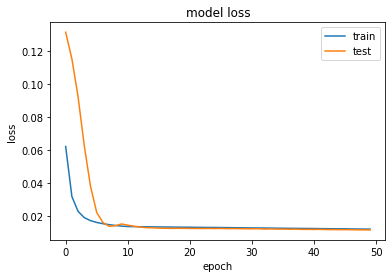

In [ ]:
TRAIN = True
epochs = 50
initial_learning_rate = 0.0001
if TRAIN:
    print('training from scratch')
    
    encoder, latent_dim = build_encoder(dim)
    decoder = build_decoder(latent_dim)

    autoencoder = build_autoencoder(encoder,decoder,initial_learning_rate)
    print('latent dimention:',latent_dim)

    autoencoder.summary()
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)
   
    history = autoencoder.fit(x=X_train_noisy,
                              y=X_train, 
                              epochs=epochs,
                              batch_size=256,
                              callbacks=[reduce_lr],
                              shuffle=True,
                          validation_data=(X_test_noisy, X_test)
                          )
    
    autoencoder.save('autoencoder.h5')
    encoder.save('encoder.h5')
    decoder.save('decoder.h5')

    plot_history(history)
else:
    print('loading existing')
    autoencoder = keras.models.load_model('autoencoder.h5')
    encoder = keras.models.load_model('encoder.h5')
    decoder = keras.models.load_model('decoder.h5')

encoding shape: (32, 32, 256)


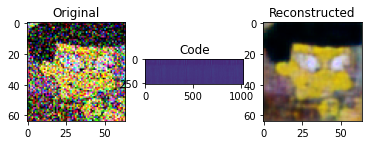

encoding shape: (32, 32, 256)


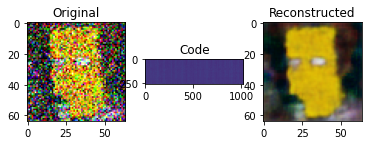

encoding shape: (32, 32, 256)


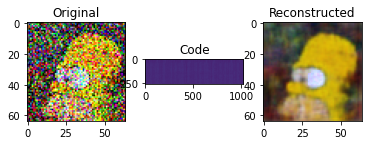

encoding shape: (32, 32, 256)


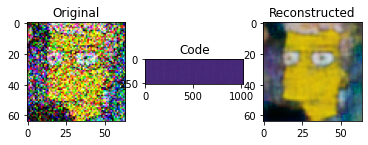

encoding shape: (32, 32, 256)


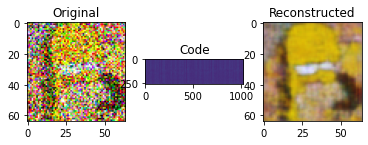

encoding shape: (32, 32, 256)


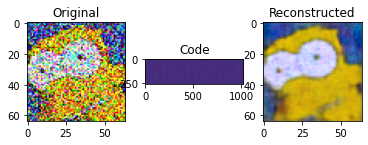

encoding shape: (32, 32, 256)


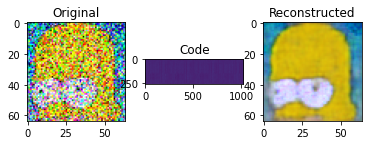

encoding shape: (32, 32, 256)


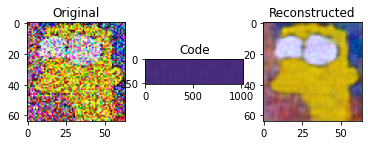

encoding shape: (32, 32, 256)


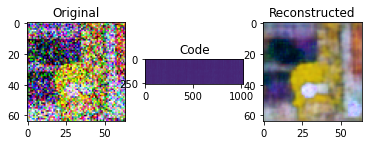

encoding shape: (32, 32, 256)


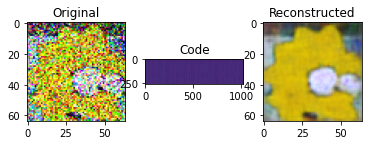

encoding shape: (32, 32, 256)


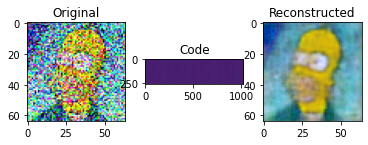

encoding shape: (32, 32, 256)


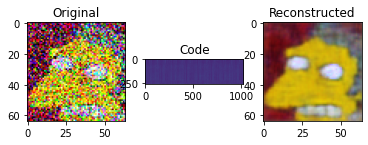

encoding shape: (32, 32, 256)


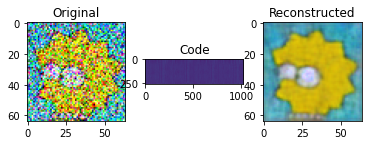

encoding shape: (32, 32, 256)


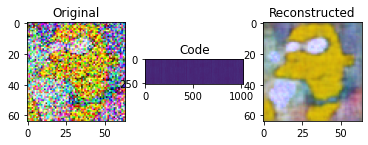

encoding shape: (32, 32, 256)


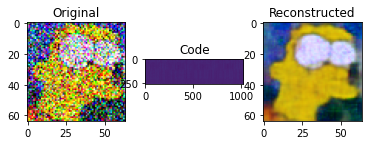

encoding shape: (32, 32, 256)


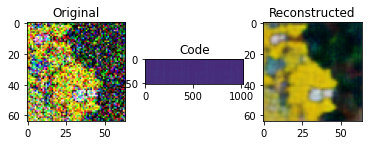

encoding shape: (32, 32, 256)


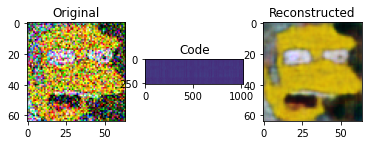

encoding shape: (32, 32, 256)


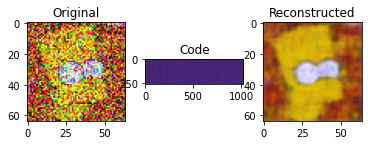

encoding shape: (32, 32, 256)


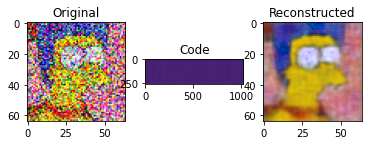

encoding shape: (32, 32, 256)


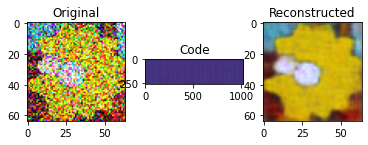

In [ ]:
for i in range(20):
    img = X_test_noisy[i]
    visualize(img, encoder, decoder)